In [1]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig , RobertaForMaskedLM
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.3.0


### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [4]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, RobertaForMaskedLM),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

### Make model selection here

In [5]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [6]:
model_class, tokenizer_class, config_class , LM_model= MODEL_CLASSES[model_type]

In [7]:
# This is the classification model
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [8]:
# This is the language model
LM_model.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, do_lower_case=True)

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
Tokenizer

fastai.text.transform.Tokenizer

In [14]:
model_type

'roberta'

In [15]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
NumericalizeProcessor

__main__.NumericalizeProcessor

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
TokenizeProcessor

fastai.text.data.TokenizeProcessor

In [20]:
# wrapper function over the tokenizer we created above
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


In [21]:
# doc(TextList)

In [22]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [22]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [23]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['the', 'Ġcat', 'Ġdidnt', 'Ġjump', 'Ġonto', 'Ġthe', 'Ġtable', ',', 'Ġbecause', 'Ġits', 'Ġtired']
[627, 4758, 46405, 3704, 2500, 5, 2103, 6, 142, 63, 7428]


['the',
 'Ġcat',
 'Ġdidnt',
 'Ġjump',
 'Ġonto',
 'Ġthe',
 'Ġtable',
 ',',
 'Ġbecause',
 'Ġits',
 'Ġtired']

## Prepare the full IMDB dataset and inspect the files under that path

In [24]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [25]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [26]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [27]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

## Data for LM training
The reviews are in a training and test folder. In addition, we have a 'unsup' folder that contains many reviews are 
are **not labelled**.<br>
In the second training phase of ULMFiT, as mentioned in the [README](https://github.com/Sylar257/Sentiment-Analysis/blob/master/README.md)
, we will be fine-tuning the language model to the domain-specific corpus.<br>
Thus, training could take advantage of using 'train', 'test', and 'unsup' folder.

### Create a DataBunch for language model
What does that mean?<br>
Basically we are creating a databunch for our learner later in a way that we ignore the true label('negataive' or  'positive'). Hence, the task we constructed is as simple as to just predict the **next word** without worrying about what the sentiment.

In [29]:
doc(TextList.label_for_lm)

In [ ]:
# we can play around with the batch_size as long as the GPU can take it
bs = 32
data_lm = (TextList.from_folder(path, processor=transformer_processor) # specify the path
           .filter_by_folder(include=['train','test','unsup']) # exclude other folders
           .split_by_rand_pct(0.1, seed=seed)                  # randomly split and keep 10% for validation set
           .label_for_lm()                                     # label as to "predict the next word token"
           .databunch(bs=bs))                                  # convert to databunch for the learner later

In [31]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(90000, 10000)

In [43]:
print(data_lm.train_ds[0][0])

<s> ĠAside Ġfrom Ġthe Ġfact Ġthat Ġthis Ġmovie Ġwas Ġfilmed Ġmostly Ġin ĠRock port ĠMA , Ġwhich Ġis Ġa Ġbeautiful Ġtown Ġwhere Ġmy Ġmother Ġonce Ġrented Ġa Ġsmall Ġstorefront Ġand ĠI Ġspent Ġmany Ġa Ġpleasant Ġsummer Ġas Ġa Ġchild , Ġit Ġis Ġfun Ġand Ġcute Ġlittle Ġfilm . Ġ< br Ġ/ >< br Ġ/> I Ġmust Ġadmit Ġthat ĠI Ġhad Ġno Ġdesire Ġto Ġactually Ġsee Ġthis Ġmovie Ġeven Ġthough ĠI Ġhave Ġa Ġweak spot Ġfor Ġromantic Ġcomed ies Ġ( I Ġdon 't Ġknow Ġwhy ). ĠThe Ġtrailers ĠI Ġsaw Ġwere Ġnot Ġappealing , Ġthe Ġcast Ġdid Ġnot Ġlook Ġthat Ġinteresting Ġand ĠI Ġhad Ġno Ġidea Ġwhat Ġthe Ġplot Ġwould Ġbe Ġabout . ĠIn Ġthe Ġend ĠI Ġfound Ġit Ġto Ġbe Ġan Ġinteresting Ġmeditation Ġon Ġrelationships Ġand Ġfamily . ĠI Ġthoroughly Ġenjoyed Ġmyself Ġand Ġmust Ġadmit Ġthat ĠI Ġthought Ġthat Ġthis Ġfilm Ġwas Ġone Ġof Ġthe Ġmost Ġoverlooked Ġgems Ġof Ġlast Ġyear . ĠI Ġam Ġdisappointed Ġthat Ġso Ġfew Ġpeople Ġseemed Ġto Ġhave Ġenjoyed Ġthe Ġvery Ġ" human - ness " Ġthat Ġthis Ġmovie Ġpresented Ġthe Ġviewer Ġwi

In [ ]:
# take a peek at a small sample of data
data_lm.show_batch()

In [ ]:
# Let's save our databunch so that we don't have to re-run this the next time
data_lm.save('lm_databunch_RoBERTa')

# Fine tuning Language Model
Important things to note here: we can't tune the language model of RoBERTa exactly the same way as ULMFiT AWD_LSTM.
The reason is because they use different training strategies. For `AWD_LSTM`, we set up language model training as predicting the **next word** or the **previous word** depending the forward/backward model that we are building. Whereas for `RoBERTa`, we need to fine-tune with masked language modeling strategy which is adopted by most of the **BERT model family** for their bidirectional mechanism.

In [23]:
import glob
import logging
import pickle
import random
import shutil
import re
import argparse
from typing import Tuple

from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from transformers import AdamW, get_linear_schedule_with_warmup

logger = logging.getLogger(__name__)

## Prepare the training files

#### Grab all seperate text files from train/test/unsup folders
Now all of the text data are under the `.fastai/data/imdb` directory by default.
In particular, there are 5 folders that we are leverage: *`train/pos ; train/neg ; test/pos ; test/neg ; unsup`*
The plan is to grab all IMDb text data that we can get our hands on and split then 90% for training language model and 10% for validation.
Note that it's better to shuffle our file glob here so that we don't get all validation text data from, say, only the `test/neg` folder

In [174]:
import random

# combine all the .txt files in the train/pos and train/neg folders
train_files = glob.glob(os.path.join((path/'train/*'),'*.txt'))
random.shuffle(train_files)

# split randomly 90% data to train_data_LM file and 10% to test_data_LM file
with open('train_data_LM.txt', 'ab') as outfile:
    for f in train_files[:int(len(train_files)*0.9)]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())
with open('test_data_LM.txt',  'ab') as outfile:
    for f in train_files[int(len(train_files)*0.9):]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())
            
# combine all the .txt files in the test/pos and test/neg folders
test_files = glob.glob(os.path.join((path/'test/*'),'*.txt'))
random.shuffle(test_files)

with open('train_data_LM.txt', 'ab') as outfile:
    for f in test_files[:int(len(test_files)*0.9)]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())
with open('test_data_LM.txt',  'ab') as outfile:
    for f in test_files[int(len(test_files)*0.9):]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())
            
            
# grab all text in the 'unsup' file as well
unsup_files = glob.glob(os.path.join((path/'unsup'),'*.txt'))
random.shuffle(unsup_files)

with open('train_data_LM.txt', 'ab') as outfile:
    for f in unsup_files[:int(len(unsup_files)*0.9)]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())
with open('test_data_LM.txt',  'ab') as outfile:
    for f in unsup_files[int(len(unsup_files)*0.9):]:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())

In [161]:
len(train_files),len(test_files),len(unsup_files)

(25000, 25000, 50000)

### Make sure files are actually shuffled
We should be seeing both `pos` and `neg` in the first 10 files of `train_files`. Same goes for `test_files`

In [175]:
train_files[:10]

['/home/projectx/.fastai/data/imdb/train/neg/9134_4.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/1173_1.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/12174_4.txt',
 '/home/projectx/.fastai/data/imdb/train/pos/8684_10.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/5122_3.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/2807_3.txt',
 '/home/projectx/.fastai/data/imdb/train/pos/3141_10.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/7203_2.txt',
 '/home/projectx/.fastai/data/imdb/train/pos/12078_8.txt',
 '/home/projectx/.fastai/data/imdb/train/neg/10622_3.txt']

In [176]:
test_files[:10]

['/home/projectx/.fastai/data/imdb/test/neg/3208_4.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/494_2.txt',
 '/home/projectx/.fastai/data/imdb/test/pos/8010_9.txt',
 '/home/projectx/.fastai/data/imdb/test/pos/779_8.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/6888_3.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/4767_3.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/1191_1.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/6846_1.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/6715_1.txt',
 '/home/projectx/.fastai/data/imdb/test/neg/5814_1.txt']

## Hyper-parameters

In [24]:
class training_param():
    def __init__(self):
        
        # general parameters
        self.train_data_file = 'train_data_LM.txt'   # train file name
        self.eval_data_file = 'test_data_LM.txt'     # test  file name
        self.model_name_or_path = 'roberta-base'# change this if using other models
        self.block_size = transformer_tokenizer.max_len_single_sentence # The training dataset will be truncated in block of this size for training. Default to the model max input length for single sentence inputs (take into account special tokens)."
        self.save_total_limit = 20              # total number of checkpoints we allow
        self.output_dir = os.path.join(os.getcwd(),'fine_tuning_LM')    # output directory for checkpoints and saves
        self.train_batch_size = 4
        self.eval_batch_size  = 4
        self.num_train_epochs = 2               # no. of epochs
        self.logging_steps    = 50
        self.save_steps       = 50
        
        # optimizer parameters
        self.learning_rate    = 5e-5
        self.weight_decay     = 0.0
        self.adam_epsilon     = 1e-8
        self.max_grad_norm    = 1.0             # max gradient norm
        self.warmup_steps     = 0               # linear warmup over warmup_steps
        
        # model parameters
        self.fp16             = False
        self.fp16_opt_level   = 'O1'            # For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']. See details at https://nvidia.github.io/apex/amp.html
        self.mlm              = True            # Training with masked-language modeling loss instead of vanilla language modeling
        self.mlm_probability  = 0.15            # Ratio of tokens to mask for masked language modeling loss
        self.device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # flags
        self.evaluate_during_training = True        
        self.overwrite_cache          = True
        self.do_train                 = True
        self.do_eval                  = True
        self.do_lower_case            = True    # True allow us to use uncased model
        self.overwrite_output_dir     = True    # overwrite the content of the output directory
        self.no_cuda                  = False   # Avoid using CUDA when it's available
        self.eval_all_checkpoints     = True    # Evaluate all checkpoints starting with the same prefix as model_name_or_path ending and ending with step number
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RoBERTa_HP = training_param()

In [26]:
RoBERTa_HP.num_train_epochs

2

In [27]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, HP, file_path="fine_tuning_LM", block_size=510):
        assert os.path.isfile(file_path)
        directory, filename = os.path.split(file_path)
        cached_features_file = os.path.join(
            directory, HP.model_name_or_path + "_cached_lm_" + str(block_size) + "_" + filename
        )

        if os.path.exists(cached_features_file) and not HP.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            with open(file_path, encoding="utf-8") as f:
                text = f.read()

            tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

            for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
                self.examples.append(tokenizer.build_inputs_with_special_tokens(tokenized_text[i : i + block_size]))
            # Note that we are loosing the last truncated example here for the sake of simplicity (no padding)
            # If your dataset is small, first you should loook for a bigger one :-) and second you
            # can change this behavior by adding (model specific) padding.

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item])


def load_and_cache_examples(HP, tokenizer, evaluate=False):
    dataset = TextDataset(
        tokenizer,
        HP,
        file_path=HP.eval_data_file if evaluate else HP.train_data_file,
        block_size=HP.block_size,
    )
    return dataset

In [28]:
def _rotate_checkpoints(HP, checkpoint_prefix, use_mtime=False):
    if not HP.save_total_limit:
        return
    if HP.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    glob_checkpoints = glob.glob(os.path.join(HP.output_dir, "{}-*".format(checkpoint_prefix)))
    if len(glob_checkpoints) <= HP.save_total_limit:
        return

    ordering_and_checkpoint_path = []
    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - HP.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to HP.save_total_limit".format(checkpoint))

In [29]:
def mask_tokens(inputs: torch.Tensor, tokenizer: PreTrainedTokenizer, HP) -> Tuple[torch.Tensor, torch.Tensor]:
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability HP.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, HP.mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [30]:
def train(HP, train_dataset, model, tokenizer=transformer_tokenizer):
    """ Train the model """
    tb_writer = SummaryWriter()

    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=HP.train_batch_size)

    t_total = len(train_dataloader)* HP.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": HP.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=HP.learning_rate, eps=HP.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=HP.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(HP.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(HP.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(HP.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(HP.model_name_or_path, "scheduler.pt")))

    if HP.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=HP.fp16_opt_level)

    
    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", HP.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", HP.train_batch_size)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(HP.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(HP.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // len(train_dataloader)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader))

        logger.info("  Continuing training from checkpoint, will skip to saved global_step")
        logger.info("  Continuing training from epoch %d", epochs_trained)
        logger.info("  Continuing training from global step %d", global_step)
        logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)

    tr_loss, logging_loss = 0.0, 0.0

    model_to_resize = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model_to_resize.resize_token_embeddings(len(tokenizer))

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(HP.num_train_epochs), desc="Epoch", disable=False
    )
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = mask_tokens(batch, tokenizer, HP) if HP.mlm else (batch, batch)
            inputs = inputs.to(HP.device)
            labels = labels.to(HP.device)
            model.train()
            outputs = model(inputs, masked_lm_labels=labels) if HP.mlm else model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if HP.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            
            if HP.fp16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), HP.max_grad_norm)
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), HP.max_grad_norm)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            global_step += 1

            if HP.logging_steps > 0 and global_step % HP.logging_steps == 0:
                # Log metrics
                if (
                    HP.evaluate_during_training
                ):  # Only evaluate when single GPU otherwise metrics may not average well
                    results = evaluate(HP, model, tokenizer)
                    for key, value in results.items():
                        tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                tb_writer.add_scalar("loss", (tr_loss - logging_loss) / HP.logging_steps, global_step)
                logging_loss = tr_loss

            if HP.save_steps > 0 and global_step % HP.save_steps == 0:
                checkpoint_prefix = "checkpoint"
                # Save model checkpoint
                output_dir = os.path.join(HP.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                model_to_save = (
                    model.module if hasattr(model, "module") else model
                )  # Take care of distributed/parallel training
                model_to_save.save_pretrained(output_dir)
                tokenizer.save_pretrained(output_dir)

                torch.save(HP, os.path.join(output_dir, "training_args.bin"))
                logger.info("Saving model checkpoint to %s", output_dir)

                _rotate_checkpoints(HP, checkpoint_prefix)

                torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                logger.info("Saving optimizer and scheduler states to %s", output_dir)

    tb_writer.close()

    return global_step, tr_loss / global_step

In [31]:
def evaluate(HP, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = HP.output_dir

    eval_dataset = load_and_cache_examples(HP, tokenizer=transformer_tokenizer, evaluate=True)

    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)

    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=HP.eval_batch_size)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", HP.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = mask_tokens(batch, tokenizer, HP) if HP.mlm else (batch, batch)
        inputs = inputs.to(HP.device)
        labels = labels.to(HP.device)

        with torch.no_grad():
            outputs = model(inputs, masked_lm_labels=labels) if HP.mlm else model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [32]:
if RoBERTa_HP.eval_data_file is None and RoBERTa_HP.do_eval:
        raise ValueError(
            "Cannot do evaluation without an evaluation data file. Either supply a file to --eval_data_file "
            "or remove the --do_eval argument."
        )

if (
    os.path.exists(RoBERTa_HP.output_dir)
    and os.listdir(RoBERTa_HP.output_dir)
    and RoBERTa_HP.do_train
    and not RoBERTa_HP.overwrite_output_dir
):
    raise ValueError(
        "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
            RoBERTa_HP.output_dir
        )
    )

# set up logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO ,
)
logger.warning(
    "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
    -1,
    device,
    1,
    False,
    RoBERTa_HP.fp16,
)

01/07/2020 18:19:25 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False


In [33]:
_, tokenizer_class, config_class , model_class = MODEL_CLASSES[model_type]

config = config_class.from_pretrained(RoBERTa_HP.model_name_or_path,
                                      do_lower_case = RoBERTa_HP.do_lower_case
                                     )

tokenizer = tokenizer_class.from_pretrained(RoBERTa_HP.model_name_or_path,
                                            do_lower_case = RoBERTa_HP.do_lower_case
                                           )


01/07/2020 18:19:32 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/projectx/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.9dad9043216064080cf9dd3711c53c0f11fe2b09313eaa66931057b4bdcaf068
01/07/2020 18:19:32 - INFO - transformers.configuration_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "

In [34]:
model = model_class.from_pretrained(
        RoBERTa_HP.model_name_or_path,
        config  = config
)
model.to(RoBERTa_HP.device);

01/07/2020 18:20:17 - INFO - transformers.modeling_utils -   loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin from cache at /home/projectx/.cache/torch/transformers/228756ed15b6d200d7cb45aaef08c087e2706f54cb912863d2efe07c89584eb7.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e


In [35]:
model.config.vocab_size

50265

# The Training Begins

In [36]:
train_dataset = load_and_cache_examples(RoBERTa_HP, tokenizer, evaluate=False)

01/07/2020 18:22:23 - INFO - __main__ -   Creating features from dataset file at 
01/07/2020 18:25:34 - INFO - __main__ -   Saving features into cached file roberta-base_cached_lm_510_train_data_LM.txt


In [37]:
test_dataset = load_and_cache_examples(RoBERTa_HP, tokenizer, evaluate=True)

01/07/2020 18:25:36 - INFO - __main__ -   Creating features from dataset file at 
01/07/2020 18:25:56 - INFO - __main__ -   Saving features into cached file roberta-base_cached_lm_510_test_data_LM.txt


In [45]:
# # The actual training/eval loops
# if RoBERTa_HP.do_train:
    
#     global_step, tr_loss = train(RoBERTa_HP, train_dataset, model, tokenizer)
#     logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)
    
#     # Create output directory if needed
#     if not os.path.exists(RoBERTa_HP.output_dir):
#         os.makedirs(RoBERTa_HP.output_dir)
        
#     logger.info("Saving model checkpoint to %s", RoBERTa_HP.output_dir)
    
#     # Save a trained model, configuration and tokenizer using `save_pretrained()`.
#     # They can then be reloaded using `from_pretrained()`
#     model_to_save = (
#         model.module if hasattr(model, "module") else model
#     )  # Take care of distributed/parallel training
#     model_to_save.save_pretrained(RoBERTa_HP.output_dir)
#     tokenizer.save_pretrained(RoBERTa_HP.output_dir)

#     # Good practice: save your training arguments together with the trained model
#     torch.save(RoBERTa_HP, os.path.join(RoBERTa_HP.output_dir, "training_args.bin"))

#     # Load a trained model and vocabulary that you have fine-tuned
#     model = model_class.from_pretrained(RoBERTa_HP.output_dir)
#     tokenizer = tokenizer_class.from_pretrained(RoBERTa_HP.output_dir, do_lower_case=RoBERTa_HP.do_lower_case)
#     model.to(RoBERTa_HP.device)

# results = {}
# if RoBERTa_HP.do_eval:
#     checkpoints = [RoBERTa_HP.output_dir]
#     if RoBERTa_HP.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(RoBERTa_HP.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    
#     logger.info("Evaluate the following checkpoints: %s", checkpoints)
#     for checkpoint in checkpoints:
#         global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
#         prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

#         model = model_class.from_pretrained(checkpoint)
#         model.to(RoBERTa_HP.device)
#         result = evaluate(RoBERTa_HP, model, tokenizer, prefix=prefix)
#         result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
#         results.update(result)

# print(results)

01/06/2020 12:28:02 - INFO - __main__ -   ***** Running training *****
01/06/2020 12:28:02 - INFO - __main__ -     Num examples = 53647
01/06/2020 12:28:02 - INFO - __main__ -     Num Epochs = 2
01/06/2020 12:28:02 - INFO - __main__ -     Instantaneous batch size per GPU = 4
01/06/2020 12:28:02 - INFO - __main__ -     Total optimization steps = 26824
Iteration:   0%|          | 0/13412 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered

In [39]:
len(train_dataset), len(test_dataset)

(53647, 5947)

In [45]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=RoBERTa_HP.train_batch_size)
t_total = len(train_dataloader)*RoBERTa_HP.num_train_epochs

# prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": RoBERTa_HP.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=RoBERTa_HP.learning_rate, eps=RoBERTa_HP.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=RoBERTa_HP.warmup_steps, 
                                            num_training_steps=t_total)

# Check if saved optimizer or schedular states exist
# If do, load them instead
if os.path.isfile(os.path.join(RoBERTa_HP.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(RoBERTa_HP.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(RoBERTa_HP.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(RoBERTa_HP.model_name_or_path, "scheduler.pt")))
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_dataset))
logger.info("  Num Epochs = %d", RoBERTa_HP.num_train_epochs)
logger.info("  Instantaneous batch size per GPU = %d", RoBERTa_HP.train_batch_size)
logger.info("  Total optimization steps = %d", t_total)

global_step = 0
epochs_trained = 0
steps_trained_in_current_epoch = 0

if os.path.exists(RoBERTa_HP.model_name_or_path):
    # set global_step to gobal_step of last saved checkpoint from model path
    global_step = int(RoBERTa_HP.model_name_or_path.split("-")[-1].split("/")[0])
    epochs_trained = global_step // len(train_dataloader)
    steps_trained_in_current_epoch = global_step % (len(train_dataloader))

    logger.info("  Continuing training from checkpoint, will skip to saved global_step")
    logger.info("  Continuing training from epoch %d", epochs_trained)
    logger.info("  Continuing training from global step %d", global_step)
    logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
    
tr_loss, logging_loss = 0.0, 0.0

model_to_resize = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
model_to_resize.resize_token_embeddings(len(tokenizer))

model.zero_grad()

train_iterator = trange(
        epochs_trained, int(RoBERTa_HP.num_train_epochs), desc="Epoch", disable=False
    )

epoch_iterator = tqdm(train_dataloader, desc='Epoch', disable=False)

01/08/2020 09:19:16 - INFO - __main__ -   ***** Running training *****
01/08/2020 09:19:16 - INFO - __main__ -     Num examples = 53647
01/08/2020 09:19:16 - INFO - __main__ -     Num Epochs = 2
01/08/2020 09:19:16 - INFO - __main__ -     Instantaneous batch size per GPU = 4
01/08/2020 09:19:16 - INFO - __main__ -     Total optimization steps = 26824
Epoch:   0%|          | 0/13412 [00:00<?, ?it/s]

In [42]:
model.cpu();

In [43]:
next(model.parameters()).is_cuda

False

In [46]:
batch = next(iter(epoch_iterator))

In [47]:
batch.shape

torch.Size([4, 512])

In [49]:
inputs, labels = mask_tokens(batch, tokenizer, RoBERTa_HP)

In [50]:
inputs.shape, labels.shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [51]:
inputs.is_cuda

False

In [52]:
inputs

tensor([[    0, 50264, 50264,  ..., 26991,  4048,     2],
        [    0,   822,    21,  ...,   393,    62,     2],
        [    0,  1368, 50264,  ...,    45,  2758,     2],
        [    0, 48709,  2527,  ..., 50264,  1461,     2]])

In [53]:
labels

tensor([[-100,  172, 3026,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, 9718,  ..., -100, -100, -100],
        [-100, -100, -100,  ...,   98, -100, -100]])

In [95]:
inputs = inputs.to(RoBERTa_HP.device)
labels = labels.to(RoBERTa_HP.device)
model.train();

In [54]:
model.train();

In [55]:
inputs.shape, labels.shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [ ]:
outputs = model(inputs, masked_lm_labels=labels)

In [59]:
outputs = model.roberta(inputs) # sequence output, pooler output

In [63]:
outputs[0].shape, outputs[1].shape

(torch.Size([4, 512, 768]), torch.Size([4, 768]))

In [64]:
sequence_output = outputs[0]

In [65]:
prediction_scores = model.lm_head(sequence_output)
prediction_scores.shape

torch.Size([4, 512, 50265])

In [75]:
prediction_scores.view(-1,model.config.vocab_size).shape

torch.Size([2048, 50265])

In [76]:
labels.view(-1).shape

torch.Size([2048])

In [77]:
from torch.nn import CrossEntropyLoss

In [85]:
loss_fct = CrossEntropyLoss(ignore_index=-1)

In [86]:
masked_lm_loss = loss_fct(prediction_scores.view(-1, model.config.vocab_size), labels.view(-1))

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:97

In [83]:
masked_lm_loss

tensor(1.8387, grad_fn=<NllLossBackward>)

In [84]:
outputs = model(inputs, masked_lm_labels=labels)

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:97

In [78]:
loss, prediction_scores = outputs[:2]

In [82]:
loss.cpu()

RuntimeError: CUDA error: device-side assert triggered

In [80]:
loss.shape, prediction_scores.shape

(torch.Size([]), torch.Size([4, 512, 50265]))

In [83]:
outputs

RuntimeError: CUDA error: device-side assert triggered

In [32]:
# # load the databunch we created ealier
# bs = 48
# data_lm = load_data(path, 'lm_databunch_RoBERTa', bs=bs)

In [33]:
# a sanity check for <s>; </s>; <pad>
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_lm.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


idx,text
0,"Ġfilm Ġwas Ġone Ġof Ġthe Ġmost Ġoverlooked Ġgems Ġof Ġlast Ġyear . ĠI Ġam Ġdisappointed Ġthat Ġso Ġfew Ġpeople Ġseemed Ġto Ġhave Ġenjoyed Ġthe Ġvery Ġ"" human - ness "" Ġthat Ġthis Ġmovie Ġpresented Ġthe Ġviewer Ġwith .< br Ġ/ >< br Ġ/> I Ġhave Ġread Ġmany Ġbad Ġreviews Ġof Ġthis Ġfilm , Ġand Ġmust Ġadmit Ġa Ġcertain Ġlevel Ġof Ġshock Ġat Ġthe Ġcynicism Ġthat Ġis Ġprevalent Ġin Ġthem ."
1,"! ĠRight Ġfrom Ġthe Ġget - go Ġyou 're Ġlaughing , Ġand Ġbelieve Ġyou Ġme , Ġdon 't Ġplan Ġon Ġresting Ġthat Ġsmile Ġof Ġyours . ĠI Ġpersonally Ġthink Ġthe Ġmovie Ġdefinitely Ġhas Ġbetter Ġmoments Ġthan Ġthe Ġfirst . ĠYou Ġknow Ġwhen Ġyou Ġgo Ġinto Ġa Ġtheater , Ġand Ġyou Ġkind Ġof Ġdon 't Ġwant Ġto Ġhave Ġhigh Ġexpectations Ġfor Ġit ..... well , Ġthis Ġmovie Ġblows Ġall Ġexpectations Ġaway"
2,"... or Ġmaybe Ġyou Ġnotice Ġit Ġhours Ġor Ġdays Ġafter Ġthe Ġfilm Ġends , Ġis Ġthat Ġyou Ġnever Ġsaw Ġany Ġsubstantial Ġplot , Ġyet Ġthe Ġthemes Ġand Ġthe Ġpoetry Ġof Ġthe Ġdialog Ġand Ġcharacters Ġnever Ġleave Ġyou . ĠIn Ġfact , Ġthe Ġtreatment Ġof Ġthe Ġrole Ġrace Ġplays Ġin Ġthe Ġeveryday Ġlives Ġof Ġthese Ġcharacters Ġis Ġalways Ġthere , Ġbut Ġit 's Ġso Ġep hemer al Ġthat Ġeven Ġthey Ġaren"
3,"br Ġ/> In Ġthe Ġbeginning , Ġthose Ġmassive Ġimages Ġcut Ġscenes Ġwere Ġreally Ġpainful Ġto Ġeyes .< br Ġ/ >< br Ġ/> Although Ġit Ġwas Ġnot Ġshown Ġwhen ĠNorman ĠReed us Ġchanged Ġcurrency Ġnotes ? ĠOr Ġis Ġit Ġme Ġstanding Ġby Ġfridge . Ġ:) </s> <s> ĠJoseph ĠConrad 's Ġtimeless Ġnovel , ĠHeart Ġof ĠDarkness , Ġwas Ġdepicted Ġin Ġthe Ġ1994 Ġmovie . ĠI Ġhave Ġread ĠConrad 's Ġnovel ,"
4,"Ġonly Ġblack Ġmale Ġon Ġthe Ġset ĠJohn ĠT oles - Bey Ġwho Ġmust Ġlook Ġat Ġthis Ġmovie Ġand Ġjust Ġwonder . ĠLook Ġhim Ġup Ġsometime Ġas Ġhe Ġhas Ġdone Ġa Ġlot Ġof Ġinteresting Ġmovies .< br Ġ/ >< br Ġ/> But Ġon Ġthis Ġmovie : ĠThe Ġscript Ġas ĠI Ġsaid Ġearlier Ġwas Ġa Ġrip - off Ġof ĠAliens Ġtweaked Ġand Ġturned Ġinto Ġa Ġsubmarine Ġ"" th r iller "". ĠIt"


### We would be feeding for each batch size of `32` and bptt of `70` (This is by defaul of FastAI)

In [34]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_lm.one_batch()
print('Batch shape : ',test_one_batch[0].shape)
test_one_batch

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([32, 70])


(tensor([[  287,    10, 12003,  ...,   172,   939,  2037],
         [    4,   318,    47,  ...,    14,    47,    58],
         [   75,  2542,     9,  ...,  2610,  5270,    36],
         ...,
         [ 1589, 49007,  3809,  ...,    42,     6,   213],
         [   16,  2679, 49069,  ...,    39, 37390,   455],
         [    2,     0,   272,  ...,     8,  6906,     9]]),
 tensor([[   10, 12003,  1294,  ...,   939,  2037,    41],
         [  318,    47,   657,  ...,    47,    58,  4441],
         [ 2542,     9,   141,  ...,  5270,    36,    90],
         ...,
         [49007,  3809, 48709,  ...,     6,   213,  1183],
         [ 2679, 49069,  3809,  ..., 37390,   455,     9],
         [    0,   272,  8508,  ...,  6906,     9,  1133]]))

## Customize model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [83]:
transformer_model.roberta??

In [98]:
# defining our model architecture 
class CustomTransformerModel_Encoder(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel_Encoder,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)
        
        return logits
    # this function is added because fastai `learner.lr_find()` will call it
    def reset(self):
        pass

Download the pretrained weights for RoBERTa

In [100]:
transformer_tokenizer.vocab_size

50265

In [101]:
# this is the configuration of language model
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = transformer_tokenizer.vocab_size
config.output_hidden_states = True
config.output_attentions = True
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 50265,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [102]:
transformer_model_LM = LM_model.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model_LM = CustomTransformerModel_Encoder(transformer_model = transformer_model_LM)

In [103]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

In [104]:
# custom_transformer_model.transformer

In [105]:
# Split layers into layer groups
def split(model, split_on:SplitFuncOrIdxList)->None:
    "Split the model at `split_on`."
    if isinstance(split_on,Callable): split_on = split_on(self.model)
    layer_groups = split_model(model, split_on)
    return layer_groups

In [65]:
# enc = custom_transformer_model.transformer.embeddings.word_embeddings
# enc

Embedding(50265, 768, padding_idx=1)

### Our decoder will share the weights of the embedding layer
This is to convert the 768 feature dimension back to probability of our 50265 vocabulary

In [66]:
# Find out whether or not we should set `tie_weights` to be True for transformers in FastAI
# `n_hid` = 768
# Also `bias` need to be True
# `output_p` set to 0.0
tfmer_lm_config

{'ctx_len': 512,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 768,
 'd_head': 64,
 'd_inner': 3072,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.0,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': False,
 'tie_weights': True,
 'out_bias': False,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mask': True}

In [67]:
# Re-construct decoder using FastAI LinearDecoder

decoder = LinearDecoder(transformer_tokenizer.vocab_size, 
                        n_hid=768, 
                        output_p=0.0,
                        tie_encoder=enc,
                        bias=True
                       )

In [68]:
decoder

LinearDecoder(
  (decoder): Linear(in_features=768, out_features=50265, bias=True)
  (output_dp): RNNDropout()
)

In [69]:
model = SequentialRNN(custom_transformer_model.transformer, decoder)
model

SequentialRNN(
  (0): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_a

In [35]:
transformer_fastai = get_language_model(Transformer, vocab_sz=50265)

In [80]:
x,y = data_lm.one_batch()
x,y

(tensor([[    7, 16679,  7768,  ...,    21,   372,    21],
         [    5,  1455,   183,  ...,    65,     9, 28505],
         [ 1235, 49069,  3809,  ...,    15,     5, 15143],
         ...,
         [    9,     5,   367,  ...,   252,  5956,    41],
         [   16,   988,     6,  ...,   101,     8,   172],
         [17743,    43,     7,  ...,     4,  7538,     5]]),
 tensor([[16679,  7768,     8,  ...,   372,    21,    14],
         [ 1455,   183,     4,  ...,     9, 28505, 49069],
         [49069,  3809,  1589,  ...,     5, 15143, 45677],
         ...,
         [    5,   367,  4133,  ...,  5956,    41,  3537],
         [  988,     6,   102,  ...,     8,   172,    88],
         [   43,     7,   492,  ...,  7538,     5,   169]]))

In [42]:
x.size(), y.size()

(torch.Size([32, 70]), torch.Size([32, 70]))

In [88]:
result[0].size(), result[1][0].size(), result[2][0].size()

(torch.Size([32, 70, 50265]),
 torch.Size([32, 70, 768]),
 torch.Size([32, 70, 768]))

In [56]:
result = transformer_fastai(x)
len(result)

3

In [81]:
result_2 = custom_transformer_model_LM(x)

the length of the ourput list is 3


In [82]:
result_2[0].size()

torch.Size([32, 70, 50265])

In [89]:
result_2[2][0].size()

torch.Size([32, 12, 70, 70])

In [90]:
custom_transformer_model_LM.transformer.lm_head

RobertaLMHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (layer_norm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
  (decoder): Linear(in_features=768, out_features=50265, bias=False)
)

In [106]:
def RoBERTa_lm_split(model:nn.Module) -> List[nn.Module]:
    "Split a RoBERTa `model` in groups for differential learning rates."
    encoder = model.transformer.roberta.encoder
    n = len(encoder.layer)//3
    groups = [list(encoder.layer[:n]), list(encoder.layer[n:2*n]), list(encoder.layer[2*n:])]
    
    return groups + [[model.transformer.roberta.embeddings.word_embeddings, model.transformer.lm_head]]

In [107]:
# tfmer_lm_split??

In [108]:
learn_lm = LanguageLearner(data_lm, 
                           custom_transformer_model_LM,
                           split_func=RoBERTa_lm_split,
                           opt_func = CustomAdamW)
learn_lm.callbacks.append(ShowGraph(learn_lm))

# Put learn in FP16 precision mode. --> Seems to not working
# if use_fp16: learn_lm = learn_lm.to_fp16()

## Layer grouping

FastAI uses layer grouping for primarily Three objectives:
1. discrimilative learning rate
2. gradual unfreezing
3. saving `state_dict` for certain parts of the network

In [110]:
learn_lm.model.transformer

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, el

In [142]:
# For roberta-language-model

list_layers = [
              [learn_lm.model.transformer.roberta.embeddings,
               learn_lm.model.transformer.roberta.encoder.layer[0],
               learn_lm.model.transformer.roberta.encoder.layer[1],
               learn_lm.model.transformer.roberta.encoder.layer[2]],
              [learn_lm.model.transformer.roberta.encoder.layer[3],
               learn_lm.model.transformer.roberta.encoder.layer[4],
               learn_lm.model.transformer.roberta.encoder.layer[5]],
              [learn_lm.model.transformer.roberta.encoder.layer[6],
               learn_lm.model.transformer.roberta.encoder.layer[7],
               learn_lm.model.transformer.roberta.encoder.layer[8]],
              [learn_lm.model.transformer.roberta.encoder.layer[9],
               learn_lm.model.transformer.roberta.encoder.layer[10]],
              [learn_lm.model.transformer.roberta.encoder.layer[11],
               learn_lm.model.transformer.roberta.pooler],
              [
               learn_lm.model.transformer.lm_head]
              ]

# list_layers = [learn_lm.model[0],
#               learn_lm.model[1]]

In [111]:
# learn_lm.split(list_layers)
num_groups = len(learn_lm.layer_groups)
print('Learner split in',num_groups,'groups')
print(learn_lm.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): BertLayer(
    (attention): BertAttention(
      (self): BertSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
  )
  (1): BertLayer(
    (attention): BertAttention(
      (s

### Now the model is split into two part Encoder and classifier which enables us to save just the encoder weights later

In [186]:
x,y = data_lm.one_batch()
x, y

(tensor([[  190,   114,    47,  ...,   817,  1472,   142],
         [  133,    86,  3974,  ...,  3809, 48709, 14699],
         [  884,     4,    38,  ...,     6,    14,    38],
         ...,
         [   19,   299, 16046,  ...,     4,    38, 16112],
         [    5,  1569,     4,  ...,  2280,   173,   259],
         [ 2439,  1416,    23,  ...,     0,    38,    33]]),
 tensor([[  114,    47,   218,  ...,  1472,   142,    51],
         [   86,  3974,     8,  ..., 48709, 14699,  2972],
         [    4,    38,   109,  ...,    14,    38,   465],
         ...,
         [  299, 16046,  2038,  ...,    38, 16112,   492],
         [ 1569,     4,   272,  ...,   173,   259,     6],
         [ 1416,    23,     5,  ...,    38,    33,   450]]))

### Freeze the model and turn it to mixed-precision mode

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 1.10E-03


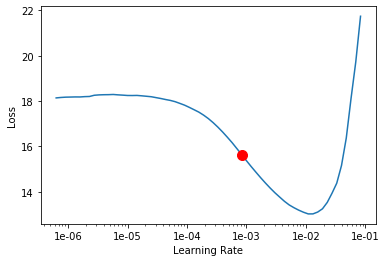

In [112]:
learn_lm.freeze()

learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.271727,0.202913,0.971420,48:22
1,0.241903,0.195251,0.972543,47:08
2,0.213293,0.180257,0.974419,46:41
3,0.190232,0.172095,0.975097,46:39
4,0.191394,0.170125,0.975388,46:41


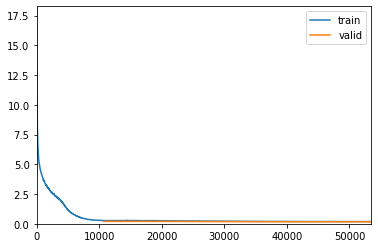

In [113]:
lr = 8.32E-04
learn_lm.fit_one_cycle(5, lr, moms=(0.8, 0.7))

In [114]:
learn_lm.save('language_model_IMDb_freezed')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


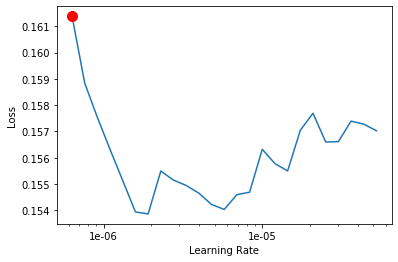

In [76]:
learn_lm.unfreeze()

learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.110532,0.086335,0.987574,1:01:32
1,0.100117,0.084309,0.987680,1:01:41
2,0.102922,0.084077,0.987677,1:01:45


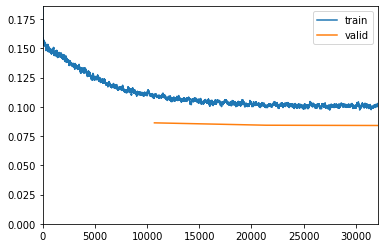

In [78]:
lr = 1e-6
learn_lm.fit_one_cycle(3, lr, moms=(0.8, 0.7))

## New our language model is more IMDb-like

In [80]:
get_model(learn_lm.model)[0].transformer

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1)
          )


## Get the encoder of the language model and save it's encoder

In [81]:
encoder = get_model(learn_lm.model)[0].transformer

In [82]:
name = 'learn_lm_encoder_IMDB'
torch.save(encoder.state_dict(), learn_lm.path/learn_lm.model_dir/f'{name}.pth')

In [83]:
(path/'models').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/models/learn_clas_unfreed_second.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/no-pre-training-freezed.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/fit_freezed_5_epochs.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/fine_tuned_lm_enc.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/tmp.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/language_model_IMDb_freezed.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/learn_clas_unfreezed_third.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/learn_clas_unfreezed_final.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/learn_lm_encoder_IMDB.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/untrained_classifier.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/no-pre-training-freez_to_-5.pth'),
 PosixPath('/home/projectx/.fastai/data/imdb/models/fine_tuned_lm.pth'),
 PosixPath('/home/projectx/.fast

# Create DataBunch for classification

In [86]:
# we can play around with the batch_size as long as the GPU can take it
bs = 16
data_clas = (TextList.from_folder(path, processor=transformer_processor) # specify the path
           .filter_by_folder(include=['train','test'])    # exclude other folders
           .split_by_folder(valid='test')                 # split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])     # label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                             # convert to databunch for the learner later

In [87]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> ĠIt 's Ġobvious Ġthat Ġthe Ġpeople Ġwho Ġmade Ġ' Dead ĠAt ĠThe ĠBox ĠOffice ' Ġlove ĠB - movie Ġhorror . ĠOvert Ġreferences Ġto Ġthe Ġgenre Ġare Ġpepp ered Ġthroughout , Ġfrom Ġstock Ġcharacters Ġ( the Ġauthority Ġfigure Ġwho Ġdoesn 't Ġbelieve Ġthe Ġmonstrous Ġinvasion Ġis Ġreally Ġhappening ) Ġto ĠKevin ĠSmith Ġstyle Ġdiscussions Ġto Ġre en acting ĠDu ane ĠJones ' Ġlast Ġmoments Ġfrom Ġ' Night Ġof Ġthe",neg
"<s> ĠThe Ġfirst Ġpart , ĠChe Ġin ĠCuba , Ġis Ġabout Ġthat Ġportion Ġof Ġhis Ġlife . ĠIt Ġcontains Ġtoo Ġmany Ġindistinguishable Ġbattles Ġand ĠChe Ġminister ing Ġto Ġtoo Ġmany Ġindistinguishable Ġwounded Ġ( remember Ġthat ĠChe Ġwas Ġa Ġphysician ). ĠIt Ġends Ġas ĠCastro Ġwins Ġthe Ġrevolution ; ĠChe Ġnever Ġgets Ġto ĠHavana . ĠThe Ġsecond Ġpart , ĠChe Ġin ĠBolivia , Ġis Ġabout Ġguess Ġwhat . ĠIt Ġcontains Ġtoo",neg
"<s> Ġ"" Mem oir s Ġof Ġa ĠGe isha "" Ġis Ġa Ġvisually Ġstunning Ġmel od rama Ġthat Ġseems Ġmore Ġlike Ġa Ġcamp , Ġdrag Ġqueen Ġsatire Ġthan Ġanything Ġto Ġdo Ġwith Ġreal Ġpeople .< br Ġ/ >< br Ġ/> The Ġfirst Ġhalf Ġof Ġthe Ġfilm Ġdefensively Ġkeeps Ġinsisting Ġthat Ġge ish as Ġare Ġneither Ġprostitutes Ġnor Ġconc ub ines , Ġthat Ġthey Ġare Ġthe Ġembodiment Ġof Ġtraditional ĠJapanese Ġbeauty",neg
"<s> ĠWow . ĠWatching Ġthis Ġfilm Ġtoday , Ġyou Ġcan 't Ġhelp Ġbut Ġbe Ġappalled Ġby Ġthe Ġwriting Ġof Ġthis Ġfilm . ĠSpencer ĠTracy Ġand ĠLore tta ĠYoung Ġplay Ġa Ġcouple Ġwho , Ġin Ġmodern Ġtimes , Ġmight Ġbe Ġfeatured Ġon Ġ"" The ĠJerry ĠSpringer ĠShow "" -- as Ġthey Ġhave Ġa Ġsick Ġand Ġabusive Ġrelationship ... and Ġinexpl icably , Ġthe Ġwriters Ġappear Ġto Ġbe Ġendorsing Ġit ! Ġ<",neg
"<s> ĠI Ġhaven 't Ġseen Ġall Ġof ĠJess ĠFranco 's Ġmovies , ĠI Ġhave Ġseen Ġ5 , ĠI Ġthink , Ġand Ġthere Ġare Ġmore Ġthan Ġ180 Ġof Ġthem . ĠSo Ġmaybe Ġit 's Ġa Ġbit Ġearly Ġto Ġsay Ġso Ġbut Ġ"" N ec ron om icon ĠGet r Ã¤ um te ĠS Ã¼ nd en "" Ġ( better Ġknown Ġas Ġ' Su cc ub us ', Ġbut Ġthat Ġis Ġthe",pos


Check numericalization

In [89]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_clas.one_batch()
print('Batch shape : ',test_one_batch[0].shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 512])
(tensor([[    0,    38,  4157,  ...,    14,   847,     2],
        [    0, 44776,  8685,  ...,   113,     8,     2],
        [    0,    20, 28609,  ..., 18756,  7560,     2],
        ...,
        [    0,    96,     5,  ...,   430,     8,     2],
        [    0, 31906,    14,  ...,  8545,     6,     2],
        [    0,    36, 19933,  ..., 17818,   322,     2]]), tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]))


In [90]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [91]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [92]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Load the encoder's pre-trained weights from the language model training

In [93]:
# loading the saved weights 
custom_transformer_model.transformer.roberta.load_state_dict(torch.load(learn_lm.path/learn_lm.model_dir/f'{name}.pth', map_location=None))

In [103]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [104]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out

In [105]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [106]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, o

In [107]:
learner.save('untrained_classifier')

In [108]:
# learner.load('untrained_classifier')

In [109]:
learner.freeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 5.25E-06


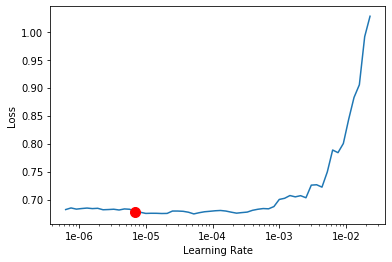

In [110]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.680777,0.683326,0.565560,0.434440,09:20
1,0.683535,0.680124,0.565920,0.434080,09:31
2,0.682704,0.677661,0.588000,0.412000,10:13


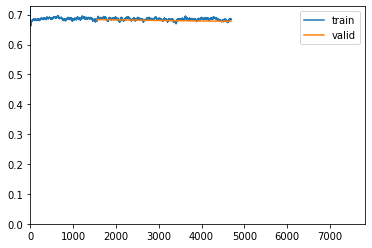

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/projectx/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + 

KeyboardInterrupt: 

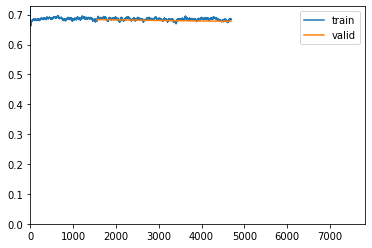

In [111]:
learner.fit_one_cycle(5, 2e-4 ,moms=(0.8,0.7))

# Old ULMFiT code for reference

In [63]:
# the drop_mult decide the percentage of dropout to use in relation to the combination used in the original paper
learn_lm_AWD = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

AssertionError: Padding_idx must be within num_embeddings

### Vocabulary
As we can see below, when we create `TextDataBunch` a  `vocab` property is created simultaneously. <br>
It's worth pointing out that, for `index-to-strings` and `strings-to-index` we have a different length. This is primarily because that there are some words that appear infrequently so that it's not effcient for them to occupy one token. What we do is to map all of these low frequency words to `xxunk`. We can ditermine the `min_freq` in the following function

In [14]:
vocab = data_lm.vocab

In [15]:
vocab.stoi["stingray"]

35055

In [16]:
vocab.stoi["happy"]

675

In [17]:
vocab.itos[vocab.stoi['mamamia']]

'xxunk'

In [18]:
len(learn_lm.model)

2

In [52]:
# ourmodel has two parts, the AWD_LSTM base architecture and the linear classifier
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

#### Comments on `drop_mult`
From the original [AWD_LSTM paper](https://arxiv.org/pdf/1708.02182.pdf) the authors applied several effective techniques.<br>

**DropConnect** was implemented in the architecture in that weight matrices are *dropped* before the *forward* and *backward* pass.<br>

**Variational dropout**. In standard dropout, a new binary dropout mask is sampled each and every time the dropout function is called. **Variational dropout** only samples a *dropout mask* upon the first call and then will repeatedly use that *locked dropout* mask for all repeated connections within the forward and backward pass.<br>

The values used for *dropout on the word vectors*, the *output between LSTM layers*, the *output of the final LSTM layer*, and *embedding dropout* were (0.4, 0.3, 0.4, 0.1), respectively.

### Encoder
Encoder is the first layer of the AWD_LSTM, which is also known as the `embedding layer`

In [20]:
enc = learn_lm.model[0].encoder
enc.weight.size()  # 400 is the embedding size

torch.Size([60000, 400])

In [21]:
# recall that 60000 is the vocab size of our language model vocabulary
len(data_lm.vocab.itos)

60000

## Before training
Let's try to use this model(only pre-trained with wiki-text) to generate fake movie reviews

In [22]:
TEXT = 'The color of the sky is'
N_WORDS = 40
N_SENTENCES = 2

In [23]:
# Note that the 'temperature' denote the randomness we adopt when pick next words
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is often changed from black to blue , to give it a more light color . The color is derived from the colours of one of the sky planets and the blue sky . The bird 's colour is

The color of the sky is a reference to the thin red hair of the Earth . The physical presence of the moon in the sky and the dark sky in the dark , and the so - called Earth - like sky


In [24]:
# If 'temperature'  set to super low, there will be almost no randomness
N_SENTENCES = 3
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.05) for _ in range(N_SENTENCES)))

The color of the sky is a matter of controversy , as the Sun is not a white sky , but a white sky . The Sun is a dark , dark , dark , dark , dark , dark , dark ,

The color of the sky is a matter of debate , and the International Union of Red and White Stars ( NAACP ) has been the most popular group of the American public . The American

The color of the sky is a matter of controversy , as the Sun has been described as a " dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark


In [25]:
# Change TEXT
TEXT = 'I hate this movie so much'
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hate this movie so much it does not last for a single , less weekly , or just a few more pages of a book , so it can be seen as Lily Allen 's second novel The Spirit of

I hate this movie so much that i think i would be thinking about it . The greatest reason why i wanted to make a movie about a movie was that you would not let it go , because it was not a chance to

I hate this movie so much that i can ' t do that . It could make you want to see what is right . But i don ' t hope to see what the right thing can do , and as many as


In [35]:
doc(LanguageLearner.predict)

### Fine-tuning a language model
We can use the `data_lm` object we created earlier to fine-tune a pretrained language model. 
Here we will be using a pre-trained `AWD-LSTM` architecture theat is available in FastAI.

In [53]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
# The plot function attached to lr_finder
# Note that we get a smoothened version where `skip_start` and `skip_end` decide howmuch to trim-off from start or end

def plot(self, skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None,
             **kwargs)->Optional[plt.Figure]:
        "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        losses = self._split_list(self.losses, skip_start, skip_end)
        losses = [x.item() for x in losses]
        if 'k' in kwargs: losses = self.smoothen_by_spline(lrs, losses, **kwargs)
        fig, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel("Learning Rate")
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        if suggestion:
            try: mg = (np.gradient(np.array(losses))).argmin()
            except:
                print("Failed to compute the gradients, there might not be enough points.")
                return
            print(f"Min numerical gradient: {lrs[mg]:.2E}")
            ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
            self.min_grad_lr = lrs[mg]
            ml = np.argmin(losses)
            print(f"Min loss divided by 10: {lrs[ml]/10:.2E}")
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

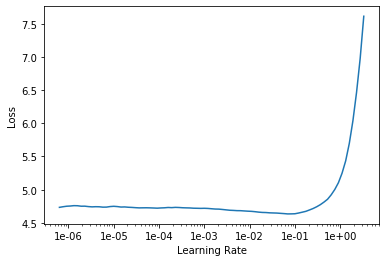

In [54]:
learn_lm.recorder.plot()

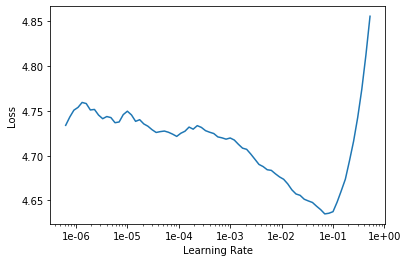

In [55]:
# Trim the last 15 datapoints so that we have clearer view
learn_lm.recorder.plot(skip_end=15)

We want to select a `learning_rate` where the slope is steep and not going upwards.<br>
`lr=5e-3` seems to be a sensible choice

In [56]:
lr=5e-3
learn_lm.to_fp16()
learn_lm.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.167812,4.067869,0.291104,21:03
1,4.200355,4.070581,0.290157,21:04
2,4.133083,4.029402,0.293869,21:05
3,4.056716,3.989157,0.298245,21:05
4,3.998321,3.979450,0.299676,21:05


In [57]:
learn_lm.save('fit_freezed_5_epochs')

In [ ]:
learn_lm.load('fit_freezed_5_epochs')

In [58]:
# now we see that the aacuracy is positively improving
# we can unfreeze and train further
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10,lr/5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.806393,3.795424,0.318980,23:47
1,3.786836,3.768348,0.324682,23:48
2,3.763445,3.743657,0.328573,23:45
3,3.717152,3.711501,0.332588,23:46
4,3.619674,3.682857,0.335828,23:45
5,3.578209,3.660896,0.338813,23:45
6,3.528988,3.642530,0.341307,23:45
7,3.461757,3.632708,0.342691,23:45
8,3.392899,3.631087,0.343060,24:03
9,3.364762,3.633080,0.342879,24:07


In [59]:
learn_lm.save('fine_tuned_lm')
learn_lm.save_encoder('fine_tuned_lm_enc')

In [60]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [62]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was true to life , a true story about a lame social worker who gets his to check out his own fantasy club . He always thinks he is an artist , but he ca n't see how

i liked this movie because of the heroic acts Richard Gere said to Richard Gere . i liked the way the film was supposed to be , and i was surprised how little was done in the moment . It


In [63]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was really bad . The acting was poor , and the story had no excitement . And the " plot " , was non - existent , and had

This movie was clearly done by people who did n't know what the TV series was . The whole story line was n't very interesting . The acting was quite


### Now the language model is much more "*IMDB like*"

In [64]:
bs = 48
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs, num_workers=1))

In [65]:
data_clas.save('imdb_textlist_classifier')

In [67]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj okay , so i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games",neg
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos


## Creating ultimate-model: IMDB review classifier
Three simple steps to create our review classifier after fine tuning our language model with IMDb dataset:
    1. Create a `text_classifier_learner` with `AWD_LSTM` as base archietecture(note that we can use any model here as base architecture, but it has to be the same with the one we just trained as language model. So if we want a transformer here, we would be training a transformer language model in the previous section)
    2. Load the `fine-tuned-language-model-encoder`. We have save both the encoder as well as the entire model. We would only be needing the encoder's weights here as we will be replacing the head as a freshly initialize classifier and train it later.
    3. Freeze the body(base architecture) of our model, and train just the head first. We can make use of our usual trategy be looking for the optimal learning rate.

In [69]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_clas.load_encoder('fine_tuned_lm_enc')
learn_clas.freeze()

In [71]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


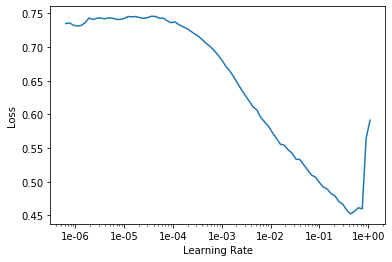

In [72]:
learn_clas.recorder.plot()

### Here we will be turning our model to mixed-precision in order to speed up the training

In [74]:
learn_clas.to_fp16();

In [75]:
learn_clas.fit_one_cycle(10, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.242503,0.202670,0.921240,02:05
1,0.245878,0.232431,0.908080,02:07
2,0.243902,0.219563,0.914240,02:25
3,0.242020,0.179243,0.933080,02:17
4,0.230897,0.175639,0.935120,02:25
5,0.225465,0.178500,0.934600,02:13
6,0.224750,0.173133,0.935280,02:26
7,0.203338,0.175705,0.934680,02:16
8,0.194384,0.172137,0.936440,02:18
9,0.212245,0.184981,0.935640,02:16


In [76]:
learn_clas.save('learn_clas_freezed')

### Gradual unfreezing during fine-tuning our classifier
Fine-tuning the target classifier is the most critical part of the *transfer learning method*. Overly aggressive fine-tuning will cause catastrophic forgetting, eliminating the benefit of the information captured through language modeling; too cautious fine-tuning will lead to slow convergence (and resultant overfiting). Besides discriminative fine-tuning and triangular learning rates, **gradual unfreezing** is proposed.

Jeremy et al. found that for RNN-base NLP models, by gradually unfreeze the layers from head to bottom we minimize the forgetting incurred for each *transfer learning* thus maximize our effort done in the previous training section.

We first unfreeze the **last layer** and fine-tune all un-frozen layers for one epoch.

Then unfreeze the **next lower frozen layer** and repeat.

Until all unfrozen layers converges.

In [78]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.222187,0.180545,0.931840,02:30
1,0.199225,0.155029,0.943760,02:45
2,0.155391,0.151604,0.945680,02:31
3,0.093648,0.169559,0.943680,02:39
4,0.058335,0.191606,0.941960,02:37


In [79]:
learn_clas.save('learn_clas_unfreed_second')

In [81]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.064002,0.204184,0.940280,03:32
1,0.090188,0.196067,0.936440,03:21
2,0.051633,0.197808,0.939760,03:08
3,0.025068,0.227497,0.944320,03:35
4,0.011097,0.242228,0.944400,03:08


In [82]:
learn_clas.save('learn_clas_unfreezed_third')

In [87]:
learn_clas.load('learn_clas_unfreezed_third');

In [88]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(15, slice(4e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.017045,0.236845,0.943680,04:11
1,0.017342,0.244636,0.944000,04:31
2,0.010597,0.256718,0.944560,04:23
3,0.010705,0.262101,0.944880,04:18
4,0.013174,0.271987,0.943320,04:18
5,0.007575,0.276141,0.943960,04:12
6,0.005873,0.276535,0.944960,03:44
7,0.010663,0.292337,0.945400,04:18
8,0.007185,0.300464,0.945200,04:26
9,0.009154,0.294201,0.944960,04:31


In [85]:
learn_clas.save('learn_clas_unfreezed_final')

The state-of-the-art result for IMDB sentimant classification result in 2017 is **94.1%**
What we can do even better, is to build a **reversed model** as well and training a meta-learner on top of that.
For this technique, we will be experimenting with more detail in my [sentiment analysis with non-English language]() repo.